In [158]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler



In [159]:
df = pd.read_csv("Downloads/creditcard.csv")

In [160]:
#rescale Time and Amount
df['normAmount']=StandardScaler().fit_transform(df['Amount'].reshape(-1,1))
df['normTime']=StandardScaler().fit_transform(df['Time'].reshape(-1,1))
#Dropping the old Time and Amount columns
df=df.drop(['Time','Amount'], axis=1)                                                

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
entire_df=df
#Undersampling
fraud_count=len(df[df.Class== 1])
fraud_index=df[df.Class== 1].index
non_fraud_index=df[df.Class==0].index
random_sample_index=np.random.choice(non_fraud_index,fraud_count,replace=False)
random_sample_index=np.array(random_sample_index)
under_sample_index=np.concatenate([random_sample_index,fraud_index])
total_undersample_dataset=df.iloc[under_sample_index,:]
y=total_undersample_dataset.Class
X=total_undersample_dataset.drop('Class', 1)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.2, random_state=42)
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
modelpredict=logreg.predict(X_test)
#accuracy_score(y_test, modelpredict, normalize=False)
#cross validation 10 folds
cv_score=cross_val_score(logreg, X_train, y_train, cv=10)

print("Mean Cross Validation Score = ",np.mean(cv_score))
print(confusion_matrix(y_test, modelpredict))
print(classification_report(y_test, modelpredict))


Mean Cross Validation Score =  0.946523044466
[[95  4]
 [11 87]]
             precision    recall  f1-score   support

          0       0.90      0.96      0.93        99
          1       0.96      0.89      0.92        98

avg / total       0.93      0.92      0.92       197



The optimal number of neighbors is 7


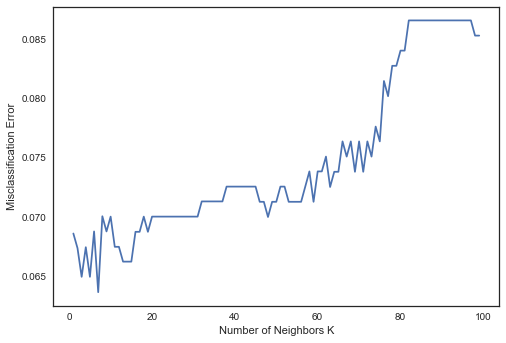

0.92385786802
             precision    recall  f1-score   support

          0       0.88      0.98      0.93        99
          1       0.98      0.87      0.92        98

avg / total       0.93      0.92      0.92       197



In [171]:
#Hyperparameter Tuning for K
K_list=list(range(1,100))

#create empty list
cv_scores=[]

#perform K search
for k in K_list:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    

#Plotting misclassification error

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = K_list[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(K_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#Look how the number of neighbors drastically increases the MSE rate

# Try KNN to see how well it predicts fraud on the undersampled dataset
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_knn_predict=knn.predict(X_test)
print (accuracy_score(y_test, y_knn_predict))
print(classification_report(y_test, y_knn_predict))

In [163]:
#applying the model trained on undersampled data to the entire dataset
y_entire=entire_df.Class
X_entire=entire_df.drop('Class', 1)
X_train_entire, X_test_entire, y_train_entire, y_test_entire=train_test_split(X_entire, y_entire, test_size=.2, random_state=42)
predict_y=logreg.predict(X_entire)
print("Classification Report = ", classification_report(y_entire, predict_y))
#cross validation
cv_score_entire=cross_val_score(logreg, X_entire, y_entire, cv=10)
print("Mean Cross Validation Score = ",np.mean(cv_score_entire))

Classification Report =               precision    recall  f1-score   support

          0       1.00      0.97      0.98    284315
          1       0.05      0.92      0.09       492

avg / total       1.00      0.97      0.98    284807

Mean Cross Validation Score =  0.999111683316


In [164]:
#by bootstrapping the number of postive occurances target a 5:1 ratio
Total_amt_pos_needed=int(len(y_entire[y_entire==0])/5)
new_data_qty=Total_amt_pos_needed-len(y_entire[y_entire==1])
all_y_pos_index=entire_df[entire_df.Class==1].index
new_y_pos_index=np.random.choice(all_y_pos_index, new_data_qty, replace=True)
new_y_pos_index=np.array(new_y_pos_index)
old_y_neg_index=entire_df[entire_df.Class==0].index
overfit_df_index=np.concatenate([new_y_pos_index,old_y_neg_index])
new_overfit_df=entire_df.iloc[overfit_df_index,:]

In [165]:
#creating new LR model based on the bootstrapped data
logreg_2=LogisticRegression()
y_overfit=new_overfit_df.Class
X_overfit=new_overfit_df.drop('Class', 1)
X_train_overfit, X_test_overfit, y_train_overfit, y_test_overfit=train_test_split(X_overfit, y_overfit, test_size=.2, random_state=42)
logreg_2.fit(X_train_overfit, y_train_overfit)
y_overfit_results=logreg_2.predict(X_test_overfit)
print("Classification Report = ", classification_report(y_test_overfit, y_overfit_results))


Classification Report =               precision    recall  f1-score   support

          0       0.98      1.00      0.99     56815
          1       0.97      0.87      0.92     11323

avg / total       0.98      0.98      0.97     68138



In [166]:
#Trying Lasso on the features
lasso=Lasso(alpha=0.4, normalize=False, random_state=42)
lasso.fit(X_train, y_train)
lasso_coef=lasso.coef_
print(lasso_coef)

[-0.          0.         -0.00895424  0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.05447203 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.        ]


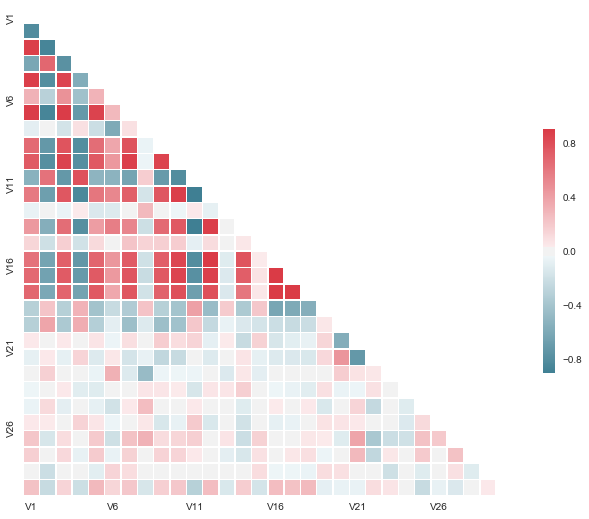

In [167]:
#checking correlation of the features
#borrowing some code for a pretty matrix

sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show() 
